# EDA and Modeling for USA flights data for Cancellation and Delay

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, dayofweek, when

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier

import pandas as pd
import numpy as np

In [2]:
spark = SparkSession \
.builder \
.appName("Flight Delay App") \
.config("spark.driver.memory", "15g") \
.config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector:10.0.5')\
.config("spark.mongodb.read.connection.uri", "mongodb://127.0.0.1/flight_db.flight_data") \
.config("spark.mongodb.write.connection.uri", "mongodb://127.0.01/flight_db.flight_data") \
.getOrCreate()

# Load data from MongoDB

In [3]:
flights_df = spark.read.format("mongodb").load()

In [4]:
flights_df.show(5)

+-------------------+--------+---------+--------+-----------------+---------+-------------+------------+------------+----------------+---------+--------+----+--------+--------+----------+-------------------+---------+----------+-----------------+------+--------------+-------+--------+-------------+----------+---------+--------------------+
|ACTUAL_ELAPSED_TIME|AIR_TIME|ARR_DELAY|ARR_TIME|CANCELLATION_CODE|CANCELLED|CARRIER_DELAY|CRS_ARR_TIME|CRS_DEP_TIME|CRS_ELAPSED_TIME|DEP_DELAY|DEP_TIME|DEST|DISTANCE|DIVERTED|   FL_DATE|LATE_AIRCRAFT_DELAY|NAS_DELAY|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|SECURITY_DELAY|TAXI_IN|TAXI_OUT|WEATHER_DELAY|WHEELS_OFF|WHEELS_ON|                 _id|
+-------------------+--------+---------+--------+-----------------+---------+-------------+------------+------------+----------------+---------+--------+----+--------+--------+----------+-------------------+---------+----------+-----------------+------+--------------+-------+--------+-------------+----------+------

In [5]:
flights_df.schema

StructType(List(StructField(ACTUAL_ELAPSED_TIME,StringType,true),StructField(AIR_TIME,StringType,true),StructField(ARR_DELAY,StringType,true),StructField(ARR_TIME,StringType,true),StructField(CANCELLATION_CODE,StringType,true),StructField(CANCELLED,StringType,true),StructField(CARRIER_DELAY,StringType,true),StructField(CRS_ARR_TIME,StringType,true),StructField(CRS_DEP_TIME,StringType,true),StructField(CRS_ELAPSED_TIME,StringType,true),StructField(DEP_DELAY,StringType,true),StructField(DEP_TIME,StringType,true),StructField(DEST,StringType,true),StructField(DISTANCE,StringType,true),StructField(DIVERTED,StringType,true),StructField(FL_DATE,StringType,true),StructField(LATE_AIRCRAFT_DELAY,StringType,true),StructField(NAS_DELAY,StringType,true),StructField(OP_CARRIER,StringType,true),StructField(OP_CARRIER_FL_NUM,StringType,true),StructField(ORIGIN,StringType,true),StructField(SECURITY_DELAY,StringType,true),StructField(TAXI_IN,StringType,true),StructField(TAXI_OUT,StringType,true),StructF

In [6]:
flights_df.createOrReplaceTempView('flights')

# Data Transformation
1. Converting columns to proper datatypes
1. Deriving new columns from existing columns

In [7]:
flights_df = flights_df.withColumn("ACTUAL_ELAPSED_TIME",col("ACTUAL_ELAPSED_TIME").cast("Integer")) \
.withColumn("AIR_TIME",col("AIR_TIME").cast("Integer")) \
.withColumn("ARR_DELAY",col("ARR_DELAY").cast("Integer")) \
.withColumn("CANCELLED",col("CANCELLED").cast("Integer")) \
.withColumn("CARRIER_DELAY",col("CARRIER_DELAY").cast("Integer")) \
.withColumn("CRS_ELAPSED_TIME",col("CRS_ELAPSED_TIME").cast("Integer")) \
.withColumn("DEP_DELAY",col("DEP_DELAY").cast("Integer")) \
.withColumn("DISTANCE",col("DISTANCE").cast("Integer")) \
.withColumn("DIVERTED",col("DIVERTED").cast("Integer")) \
.withColumn("NAS_DELAY",col("NAS_DELAY").cast("Integer")) \
.withColumn("SECURITY_DELAY",col("SECURITY_DELAY").cast("Integer")) \
.withColumn("TAXI_IN",col("TAXI_IN").cast("Integer")) \
.withColumn("TAXI_OUT",col("TAXI_OUT").cast("Integer")) \
.withColumn("WEATHER_DELAY",col("WEATHER_DELAY").cast("Integer")) \
.withColumn("SECURITY_DELAY",col("SECURITY_DELAY").cast("Integer")) \
.withColumn('HOUR_OF_THE_DAY', flights_df.CRS_DEP_TIME.substr(0,2).cast("Integer")) \
.withColumn('MONTH', flights_df.FL_DATE.substr(6,2).cast("Integer")) \
.withColumn('DAY_OF_THE_MONTH', flights_df.FL_DATE.substr(9,2).cast("Integer")) \
.withColumn('DAY_OF_THE_WEEK', dayofweek(date_format(col("FL_DATE"), "yyyy-MM-dd")))

flights_df = flights_df.withColumn("DELAYED",when(flights_df.ARR_DELAY >= 10,1).otherwise(0))

In [8]:
flights_df.schema

StructType(List(StructField(ACTUAL_ELAPSED_TIME,IntegerType,true),StructField(AIR_TIME,IntegerType,true),StructField(ARR_DELAY,IntegerType,true),StructField(ARR_TIME,StringType,true),StructField(CANCELLATION_CODE,StringType,true),StructField(CANCELLED,IntegerType,true),StructField(CARRIER_DELAY,IntegerType,true),StructField(CRS_ARR_TIME,StringType,true),StructField(CRS_DEP_TIME,StringType,true),StructField(CRS_ELAPSED_TIME,IntegerType,true),StructField(DEP_DELAY,IntegerType,true),StructField(DEP_TIME,StringType,true),StructField(DEST,StringType,true),StructField(DISTANCE,IntegerType,true),StructField(DIVERTED,IntegerType,true),StructField(FL_DATE,StringType,true),StructField(LATE_AIRCRAFT_DELAY,StringType,true),StructField(NAS_DELAY,IntegerType,true),StructField(OP_CARRIER,StringType,true),StructField(OP_CARRIER_FL_NUM,StringType,true),StructField(ORIGIN,StringType,true),StructField(SECURITY_DELAY,IntegerType,true),StructField(TAXI_IN,IntegerType,true),StructField(TAXI_OUT,IntegerType,

In [9]:
flights_df.show(5)

+-------------------+--------+---------+--------+-----------------+---------+-------------+------------+------------+----------------+---------+--------+----+--------+--------+----------+-------------------+---------+----------+-----------------+------+--------------+-------+--------+-------------+----------+---------+--------------------+---------------+-----+----------------+---------------+-------+
|ACTUAL_ELAPSED_TIME|AIR_TIME|ARR_DELAY|ARR_TIME|CANCELLATION_CODE|CANCELLED|CARRIER_DELAY|CRS_ARR_TIME|CRS_DEP_TIME|CRS_ELAPSED_TIME|DEP_DELAY|DEP_TIME|DEST|DISTANCE|DIVERTED|   FL_DATE|LATE_AIRCRAFT_DELAY|NAS_DELAY|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|SECURITY_DELAY|TAXI_IN|TAXI_OUT|WEATHER_DELAY|WHEELS_OFF|WHEELS_ON|                 _id|HOUR_OF_THE_DAY|MONTH|DAY_OF_THE_MONTH|DAY_OF_THE_WEEK|DELAYED|
+-------------------+--------+---------+--------+-----------------+---------+-------------+------------+------------+----------------+---------+--------+----+--------+--------+----------+---

In [10]:
flights_df.columns

['ACTUAL_ELAPSED_TIME',
 'AIR_TIME',
 'ARR_DELAY',
 'ARR_TIME',
 'CANCELLATION_CODE',
 'CANCELLED',
 'CARRIER_DELAY',
 'CRS_ARR_TIME',
 'CRS_DEP_TIME',
 'CRS_ELAPSED_TIME',
 'DEP_DELAY',
 'DEP_TIME',
 'DEST',
 'DISTANCE',
 'DIVERTED',
 'FL_DATE',
 'LATE_AIRCRAFT_DELAY',
 'NAS_DELAY',
 'OP_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN',
 'SECURITY_DELAY',
 'TAXI_IN',
 'TAXI_OUT',
 'WEATHER_DELAY',
 'WHEELS_OFF',
 'WHEELS_ON',
 '_id',
 'HOUR_OF_THE_DAY',
 'MONTH',
 'DAY_OF_THE_MONTH',
 'DAY_OF_THE_WEEK',
 'DELAYED']

In [11]:
flights_df.createOrReplaceTempView('flights')

# Modeling for predicting if flight can get Cancelled

### Feature selection
Selected 'DAY_OF_THE_WEEK', 'DAY_OF_THE_MONTH', 'MONTH', 'HOUR_OF_THE_DAY', 'OP_CARRIER', 'ORIGIN', 'DEST' for Predicting Cancellation 

In [12]:
categoricalColumns = ['DAY_OF_THE_WEEK', 'DAY_OF_THE_MONTH', 'MONTH', 'HOUR_OF_THE_DAY', 'OP_CARRIER', 'ORIGIN', 'DEST']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'CANCELLED', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['DISTANCE']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [13]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(flights_df)
flights_df = pipelineModel.transform(flights_df)
selectedCols = ['label', 'features']
sparkDF = flights_df.select(selectedCols)

### Spliting data to train and test with 80 to 20 pecentage

In [14]:
train, test = sparkDF.randomSplit([0.8, 0.2], seed = 124)
print("Training count: " + str(train.count()))
print("Testing count: " + str(test.count()))

Training count: 10310733
Testing count: 2578097


### Decision Tree Classifier

In [15]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label',maxDepth = 3)
dtModel = dt.fit(train)

In [16]:
result = dtModel.transform(test)
result.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(865,[0,19,46,47,...|[9938946.0,150015.0]|[0.98513077808507...|       0.0|
|  0.0|(865,[0,19,46,47,...|[9938946.0,150015.0]|[0.98513077808507...|       0.0|
|  0.0|(865,[0,19,46,47,...|[9938946.0,150015.0]|[0.98513077808507...|       0.0|
|  0.0|(865,[0,19,46,47,...|[9938946.0,150015.0]|[0.98513077808507...|       0.0|
|  0.0|(865,[0,19,46,47,...|[9938946.0,150015.0]|[0.98513077808507...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [17]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC AUC Curve', evaluator.evaluate(result))

Test Area Under ROC AUC Curve 0.4803931646900266


### Logistic Regression

In [18]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [19]:
predictions = lrModel.transform(test)
predictions.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(865,[0,19,46,47,...|[3.36663972200548...|[0.96664551893516...|       0.0|
|  0.0|(865,[0,19,46,47,...|[4.54899897235426...|[0.98953293069360...|       0.0|
|  0.0|(865,[0,19,46,47,...|[3.54223854015787...|[0.97186598399422...|       0.0|
|  0.0|(865,[0,19,46,47,...|[4.06785947490997...|[0.98317397800456...|       0.0|
|  0.0|(865,[0,19,46,47,...|[4.55239349735794...|[0.98956803115822...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [20]:
evaluator2 = BinaryClassificationEvaluator()
print('Test Area Under ROC AUC Curve', evaluator2.evaluate(predictions))

Test Area Under ROC AUC Curve 0.7457349438544087


# Modeling for predicting if flight can get delayed

### Feature selection
Selected 'DAY_OF_THE_WEEK', 'DAY_OF_THE_MONTH', 'MONTH', 'HOUR_OF_THE_DAY', 'OP_CARRIER', 'ORIGIN', 'DEST' for Predicting Delayed same as for Cancelled

In [22]:
stages = []
    
label_stringIdx = StringIndexer(inputCol = 'DELAYED', outputCol = 'label_1')
stages += [label_stringIdx]

In [23]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(flights_df)
flights_df = pipelineModel.transform(flights_df)
selectedCols = ['label_1', 'features']
sparkDF = flights_df.select(selectedCols)

### Spliting data to train and test with 80 to 20 pecentage

In [24]:
train, test = sparkDF.randomSplit([0.8, 0.2], seed = 124)
print("Training count: " + str(train.count()))
print("Testing count: " + str(test.count()))

Training count: 10310273
Testing count: 2578262


### Decision Tree Classifier

In [25]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label_1',maxDepth = 3)
dtModel = dt.fit(train)

In [26]:
result = dtModel.transform(test)
result.show(5)

+-------+--------------------+--------------------+--------------------+----------+
|label_1|            features|       rawPrediction|         probability|prediction|
+-------+--------------------+--------------------+--------------------+----------+
|    0.0|(865,[0,19,46,47,...|[7989301.0,232079...|[0.77490081323207...|       0.0|
|    0.0|(865,[0,19,46,47,...|[7989301.0,232079...|[0.77490081323207...|       0.0|
|    0.0|(865,[0,19,46,47,...|[7989301.0,232079...|[0.77490081323207...|       0.0|
|    0.0|(865,[0,19,46,47,...|[7989301.0,232079...|[0.77490081323207...|       0.0|
|    0.0|(865,[0,19,46,47,...|[7989301.0,232079...|[0.77490081323207...|       0.0|
+-------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [28]:
evaluator = BinaryClassificationEvaluator(labelCol='label_1')
print('Test Area Under ROC AUC Curve', evaluator.evaluate(result))

Test Area Under ROC AUC Curve 0.5


### Logistic Regression

In [29]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label_1', maxIter=10)
lrModel = lr.fit(train)

In [30]:
predictions = lrModel.transform(test)
predictions.show(5)

+-------+--------------------+--------------------+--------------------+----------+
|label_1|            features|       rawPrediction|         probability|prediction|
+-------+--------------------+--------------------+--------------------+----------+
|    0.0|(865,[0,19,46,47,...|[0.67257143578701...|[0.66207870735526...|       0.0|
|    0.0|(865,[0,19,46,47,...|[0.56048966574229...|[0.63656583191389...|       0.0|
|    0.0|(865,[0,19,46,47,...|[0.62432823436126...|[0.65120229675522...|       0.0|
|    0.0|(865,[0,19,46,47,...|[0.44611761086446...|[0.60971576563554...|       0.0|
|    0.0|(865,[0,19,46,47,...|[0.66656768976962...|[0.66073418200991...|       0.0|
+-------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [31]:
evaluator2 = BinaryClassificationEvaluator(labelCol='label_1')
print('Test Area Under ROC AUC Curve', evaluator2.evaluate(predictions))

Test Area Under ROC AUC Curve 0.643988762562642


## Visualizations

In [33]:
df = flights_df.groupBy("ORIGIN").sum("CANCELLED")
df2 = flights_df.groupBy("ORIGIN").count()
df3 = flights_df.groupBy("ORIGIN").avg("ARR_DELAY")
pdf = df.join(df2,"ORIGIN","inner").join(df3, "ORIGIN","inner").toPandas().sort_values(by = 'count', ascending=False)
pdf.head(20)

,ORIGIN,sum(CANCELLED),count,avg(ARR_DELAY)
226,ATL,7963,754701,3.515817
246,ORD,10855,599413,8.614471
199,DFW,7233,460506,8.529180
119,DEN,3073,459154,4.550211
301,LAX,4005,435783,3.570133
220,SFO,5709,350480,8.016182
152,CLT,7309,346412,6.586780
191,PHX,2174,328470,3.197818
109,LAS,2491,312833,4.662895
64,IAH,5341,303077,2.747583


In [35]:
df = flights_df.groupBy("DEST").sum("CANCELLED")
df2 = flights_df.groupBy("DEST").count()
df3 = flights_df.groupBy("DEST").avg("ARR_DELAY")
pdf1 = df.join(df2,"DEST","inner").join(df3, "DEST","inner").toPandas().sort_values(by = 'count', ascending=False)
pdf1.head(20)

,DEST,sum(CANCELLED),count,avg(ARR_DELAY)
225,ATL,8112,754675,2.370684
246,ORD,11527,599319,6.683440
199,DFW,7903,460480,5.322886
119,DEN,3502,459254,2.251223
300,LAX,4220,435828,4.225820
220,SFO,5817,350613,11.781724
151,CLT,8038,346395,2.363554
191,PHX,2792,328451,3.234068
109,LAS,2404,312878,3.780590
64,IAH,5563,303006,2.052951


In [36]:
df = flights_df.groupBy("DAY_OF_THE_WEEK").sum("CANCELLED")
df2 = flights_df.groupBy("DAY_OF_THE_WEEK").count()
df3 = flights_df.groupBy("DAY_OF_THE_WEEK").avg("ARR_DELAY")
pdf2 = df.join(df2,"DAY_OF_THE_WEEK","inner").join(df3, "DAY_OF_THE_WEEK","inner").toPandas().sort_values(by = 'count', ascending=False)
pdf2.head(20)

,DAY_OF_THE_WEEK,sum(CANCELLED),count,avg(ARR_DELAY)
1,6,31545,1925021,7.135994
6,2,30801,1924952,6.148750
3,5,30834,1912629,6.194661
4,4,31268,1877646,3.524860
2,3,31997,1852577,3.681480
0,1,24492,1829685,3.970659
5,7,18340,1565557,1.827845


In [37]:
df = flights_df.groupBy("MONTH").sum("CANCELLED")
df2 = flights_df.groupBy("MONTH").count()
df3 = flights_df.groupBy("MONTH").avg("ARR_DELAY")
pdf3 = df.join(df2,"MONTH","inner").join(df3, "MONTH","inner").toPandas().sort_values(by = 'count', ascending=False)
pdf3.head(20)

,MONTH,sum(CANCELLED),count,avg(ARR_DELAY)
7,8,23360,1155124,8.387503
6,7,16840,1154369,8.742804
5,6,16073,1120459,8.777683
4,5,11194,1103012,5.925216
2,3,25807,1100584,3.047836
9,10,7788,1095898,2.103968
3,4,13649,1064375,5.236692
11,12,12076,1058047,3.451129
8,9,23475,1044476,1.326472
10,11,7672,1040340,1.558474


In [86]:
df = flights_df.groupBy("OP_CARRIER").sum("CANCELLED")
df2 = flights_df.groupBy("OP_CARRIER").count()
df3 = flights_df.groupBy("OP_CARRIER").avg("ARR_DELAY")
pdf4 = df.join(df2,"OP_CARRIER","inner").join(df3, "OP_CARRIER","inner").toPandas().sort_values(by = 'count', ascending=False)
pdf4.head(20)

,OP_CARRIER,sum(CANCELLED),count,avg(ARR_DELAY)
16,WN,36321,2681996,4.780842
5,DL,12488,1872843,-0.184080
2,AA,27083,1813166,4.649097
6,OO,21068,1480664,7.062432
0,UA,10862,1206046,3.814712
4,B6,14707,603664,11.208002
3,EV,15636,542431,8.316839
14,AS,3715,430829,-0.015064
1,NK,6878,332996,5.362691
13,YX,10100,316090,3.076687


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

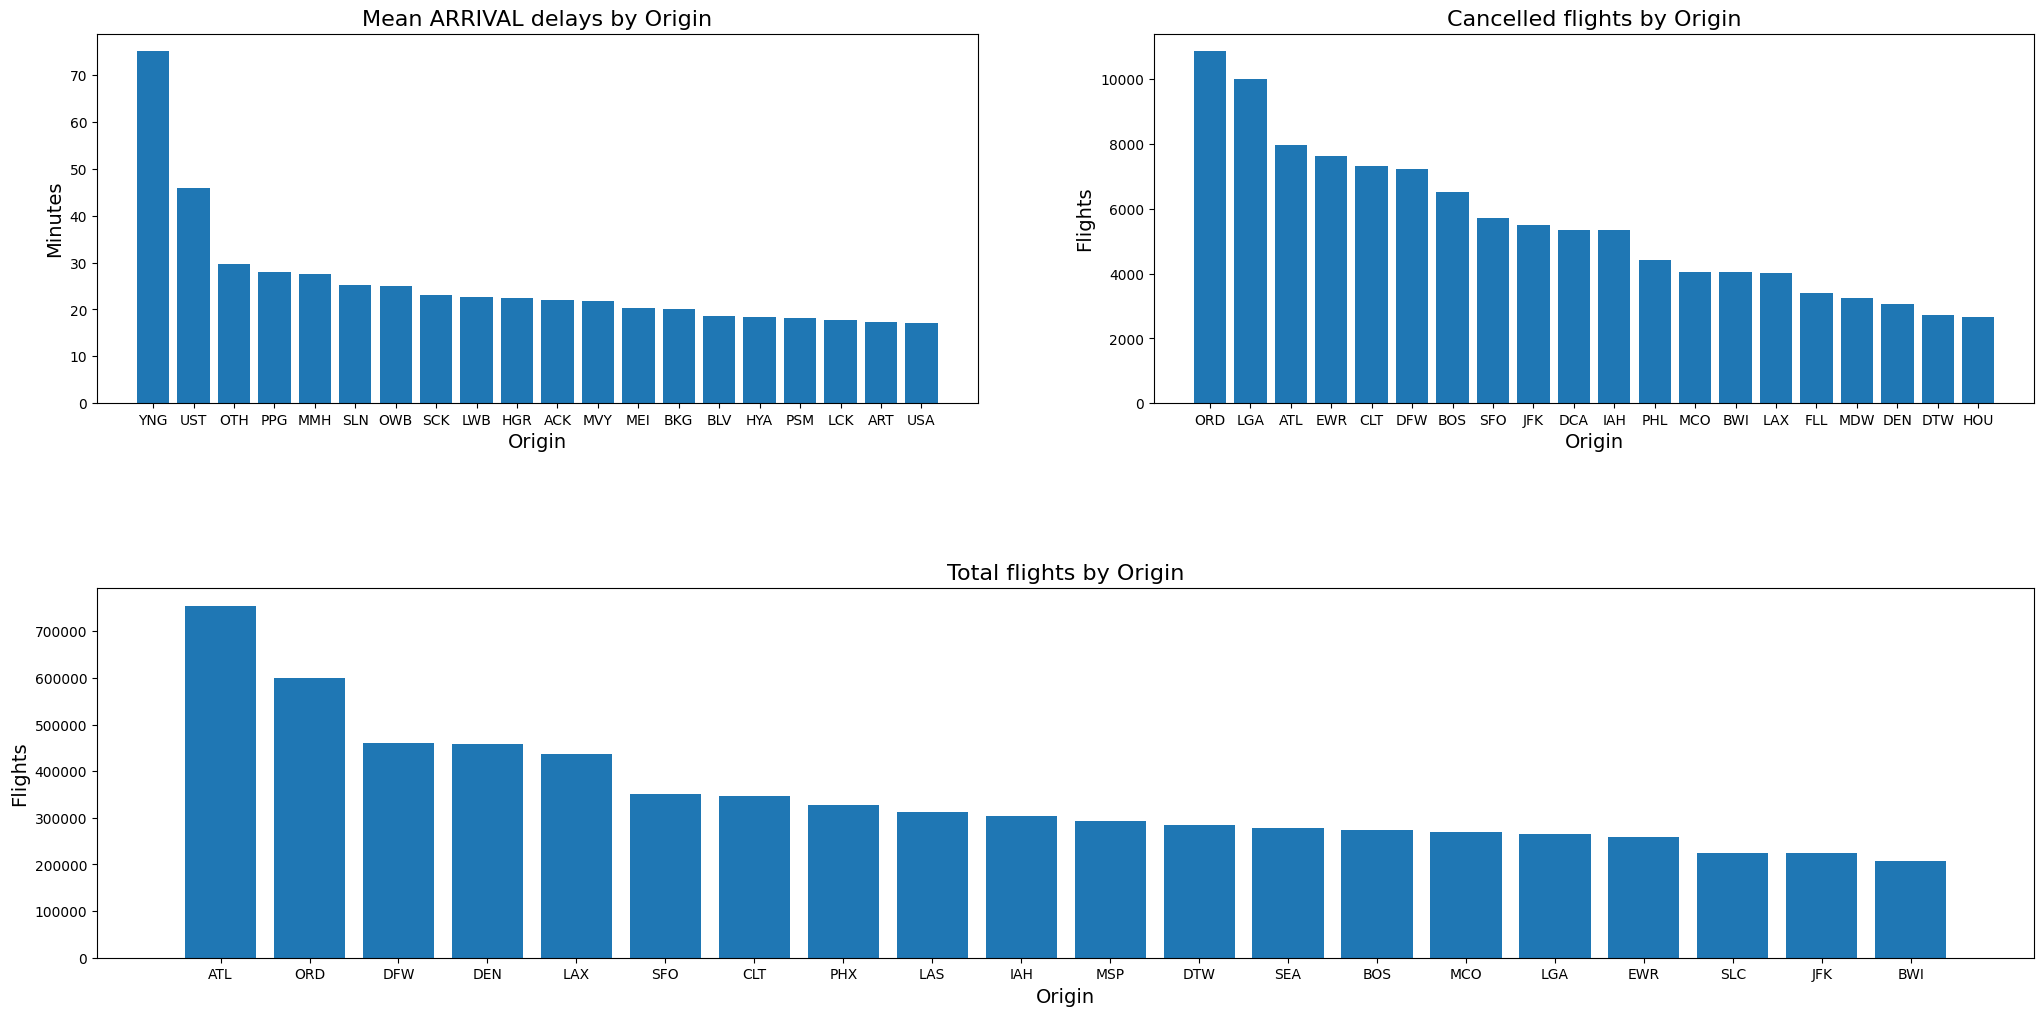

In [81]:
plt.figure(figsize=(25, 12)).subplots_adjust(hspace = 0.5)

temp_pdf= pdf.sort_values(by = 'count', ascending=False).head(20)

ax = plt.subplot(2, 1 ,2)
ax.bar(temp_pdf.ORIGIN.values, temp_pdf['count'].values)
plt.title('Total flights by Origin', fontsize=16)
plt.ylabel('Flights', fontsize=14)
plt.xlabel('Origin', fontsize=14)


temp_pdf= pdf.sort_values(by = 'avg(ARR_DELAY)', ascending=False).head(20)

ax = plt.subplot(2, 2 ,1)
ax.bar(temp_pdf.ORIGIN.values, temp_pdf['avg(ARR_DELAY)'].values)
plt.title('Mean ARRIVAL delays by Origin', fontsize=16)
plt.ylabel('Minutes', fontsize=14)
plt.xlabel('Origin', fontsize=14)


temp_pdf= pdf.sort_values(by = 'sum(CANCELLED)', ascending=False).head(20)

ax = plt.subplot(2, 2 ,2)
ax.bar(temp_pdf.ORIGIN.values, temp_pdf['sum(CANCELLED)'].values)
plt.title('Cancelled flights by Origin', fontsize=16)
plt.ylabel('Flights', fontsize=14)
plt.xlabel('Origin', fontsize=14)


plt.show()

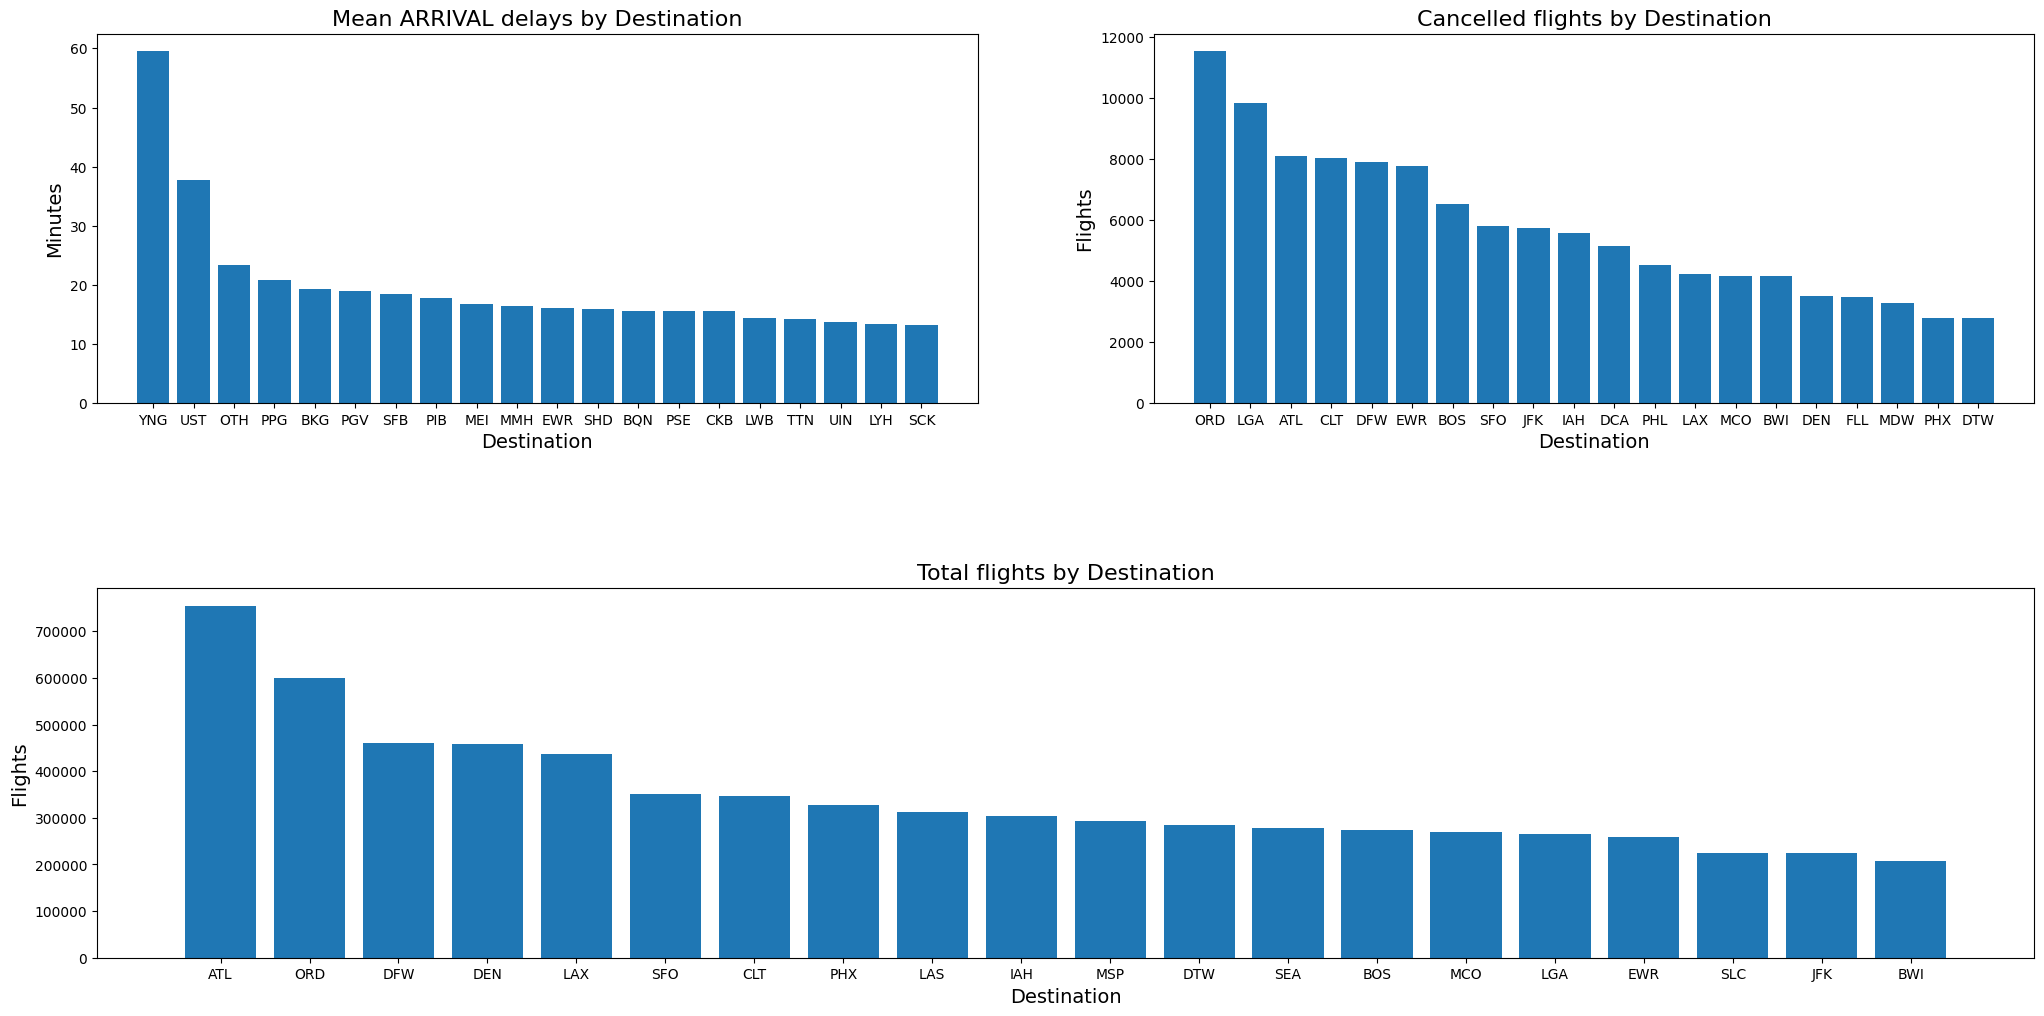

In [82]:
plt.figure(figsize=(25, 12)).subplots_adjust(hspace = 0.5)

temp_pdf= pdf1.sort_values(by = 'count', ascending=False).head(20)

ax = plt.subplot(2, 1 ,2)
ax.bar(temp_pdf.DEST.values, temp_pdf['count'].values)
plt.title('Total flights by Destination', fontsize=16)
plt.ylabel('Flights', fontsize=14)
plt.xlabel('Destination', fontsize=14)


temp_pdf= pdf1.sort_values(by = 'avg(ARR_DELAY)', ascending=False).head(20)

ax = plt.subplot(2, 2 ,1)
ax.bar(temp_pdf.DEST.values, temp_pdf['avg(ARR_DELAY)'].values)
plt.title('Mean ARRIVAL delays by Destination', fontsize=16)
plt.ylabel('Minutes', fontsize=14)
plt.xlabel('Destination', fontsize=14)


temp_pdf= pdf1.sort_values(by = 'sum(CANCELLED)', ascending=False).head(20)

ax = plt.subplot(2, 2 ,2)
ax.bar(temp_pdf.DEST.values, temp_pdf['sum(CANCELLED)'].values)
plt.title('Cancelled flights by Destination', fontsize=16)
plt.ylabel('Flights', fontsize=14)
plt.xlabel('Destination', fontsize=14)


plt.show()

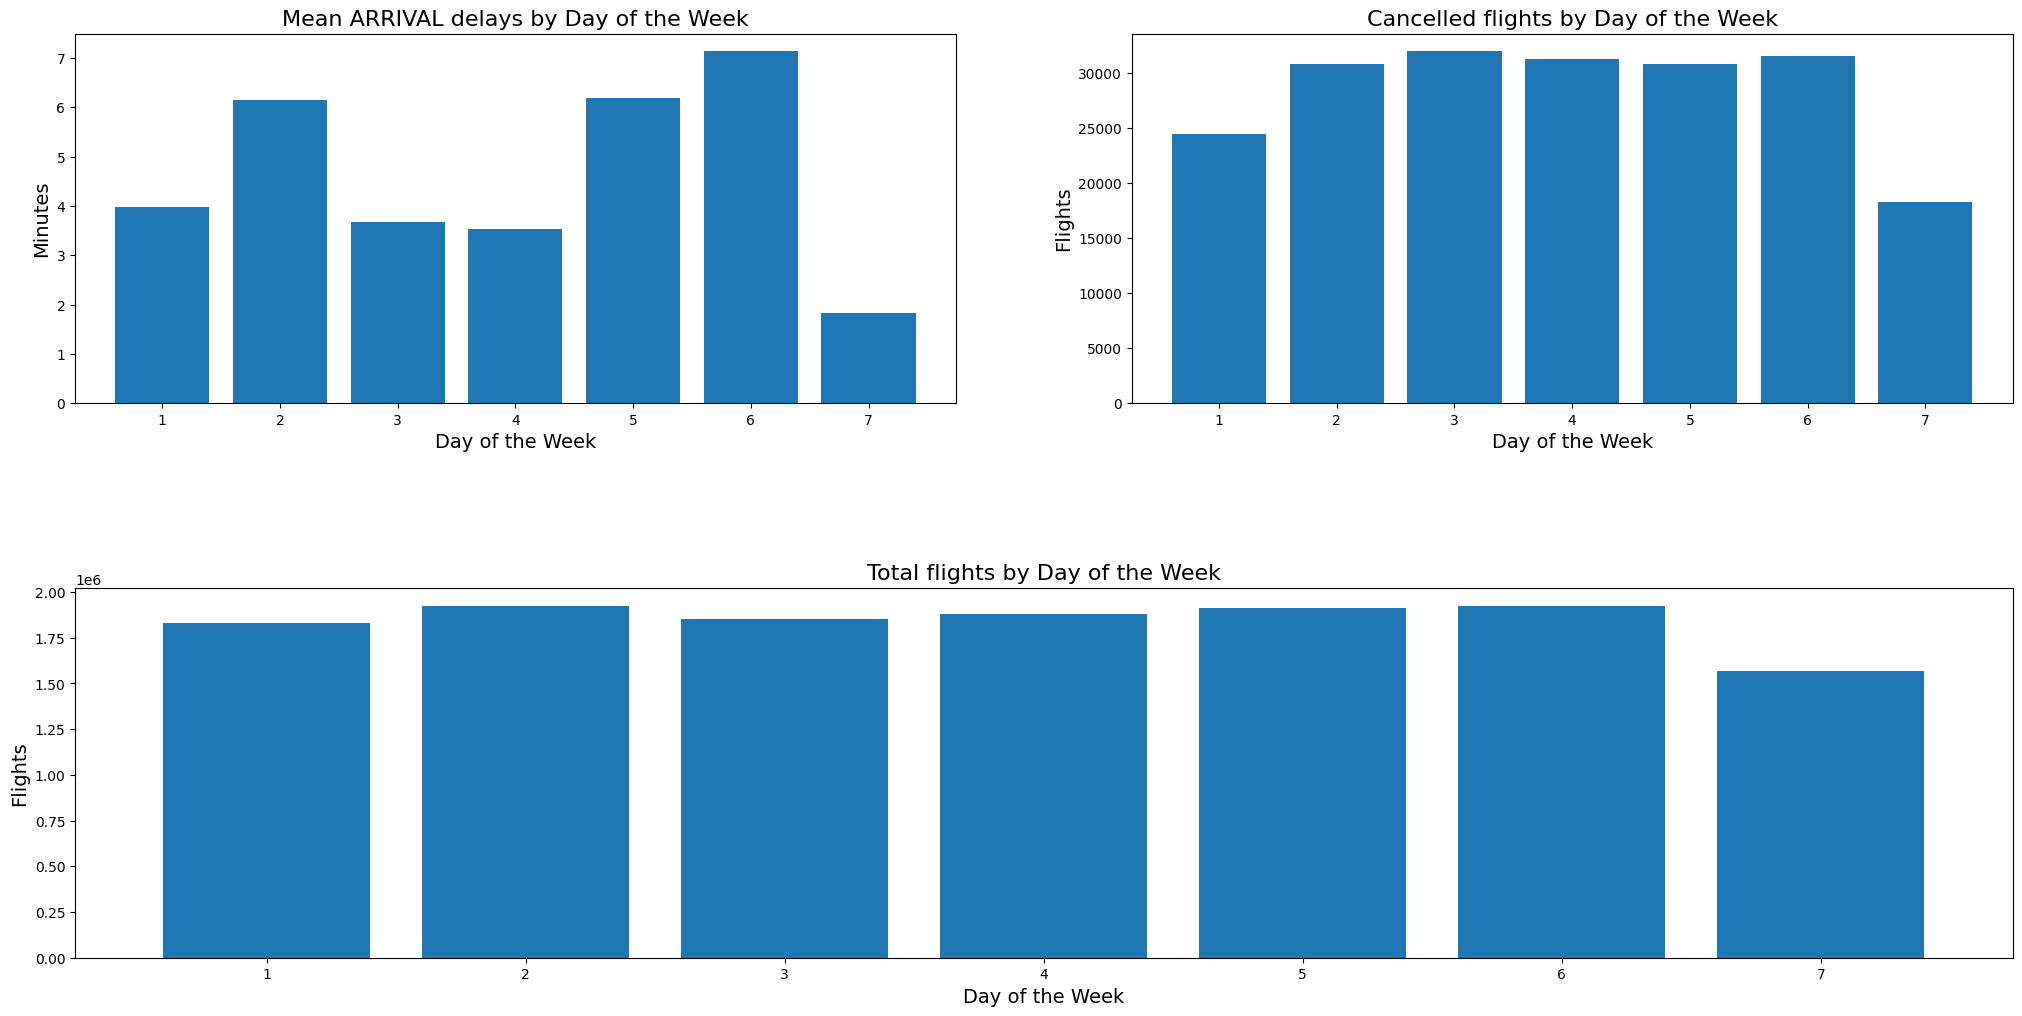

In [84]:
plt.figure(figsize=(25, 12)).subplots_adjust(hspace = 0.5)

temp_pdf= pdf2.sort_values(by = 'count', ascending=False)

ax = plt.subplot(2, 1 ,2)
ax.bar(temp_pdf.DAY_OF_THE_WEEK.values, temp_pdf['count'].values)
plt.title('Total flights by Day of the Week', fontsize=16)
plt.ylabel('Flights', fontsize=14)
plt.xlabel('Day of the Week', fontsize=14)


temp_pdf= pdf2.sort_values(by = 'avg(ARR_DELAY)', ascending=False)

ax = plt.subplot(2, 2 ,1)
ax.bar(temp_pdf.DAY_OF_THE_WEEK.values, temp_pdf['avg(ARR_DELAY)'].values)
plt.title('Mean ARRIVAL delays by Day of the Week', fontsize=16)
plt.ylabel('Minutes', fontsize=14)
plt.xlabel('Day of the Week', fontsize=14)


temp_pdf= pdf2.sort_values(by = 'sum(CANCELLED)', ascending=False)

ax = plt.subplot(2, 2 ,2)
ax.bar(temp_pdf.DAY_OF_THE_WEEK.values, temp_pdf['sum(CANCELLED)'].values)
plt.title('Cancelled flights by Day of the Week', fontsize=16)
plt.ylabel('Flights', fontsize=14)
plt.xlabel('Day of the Week', fontsize=14)


plt.show()

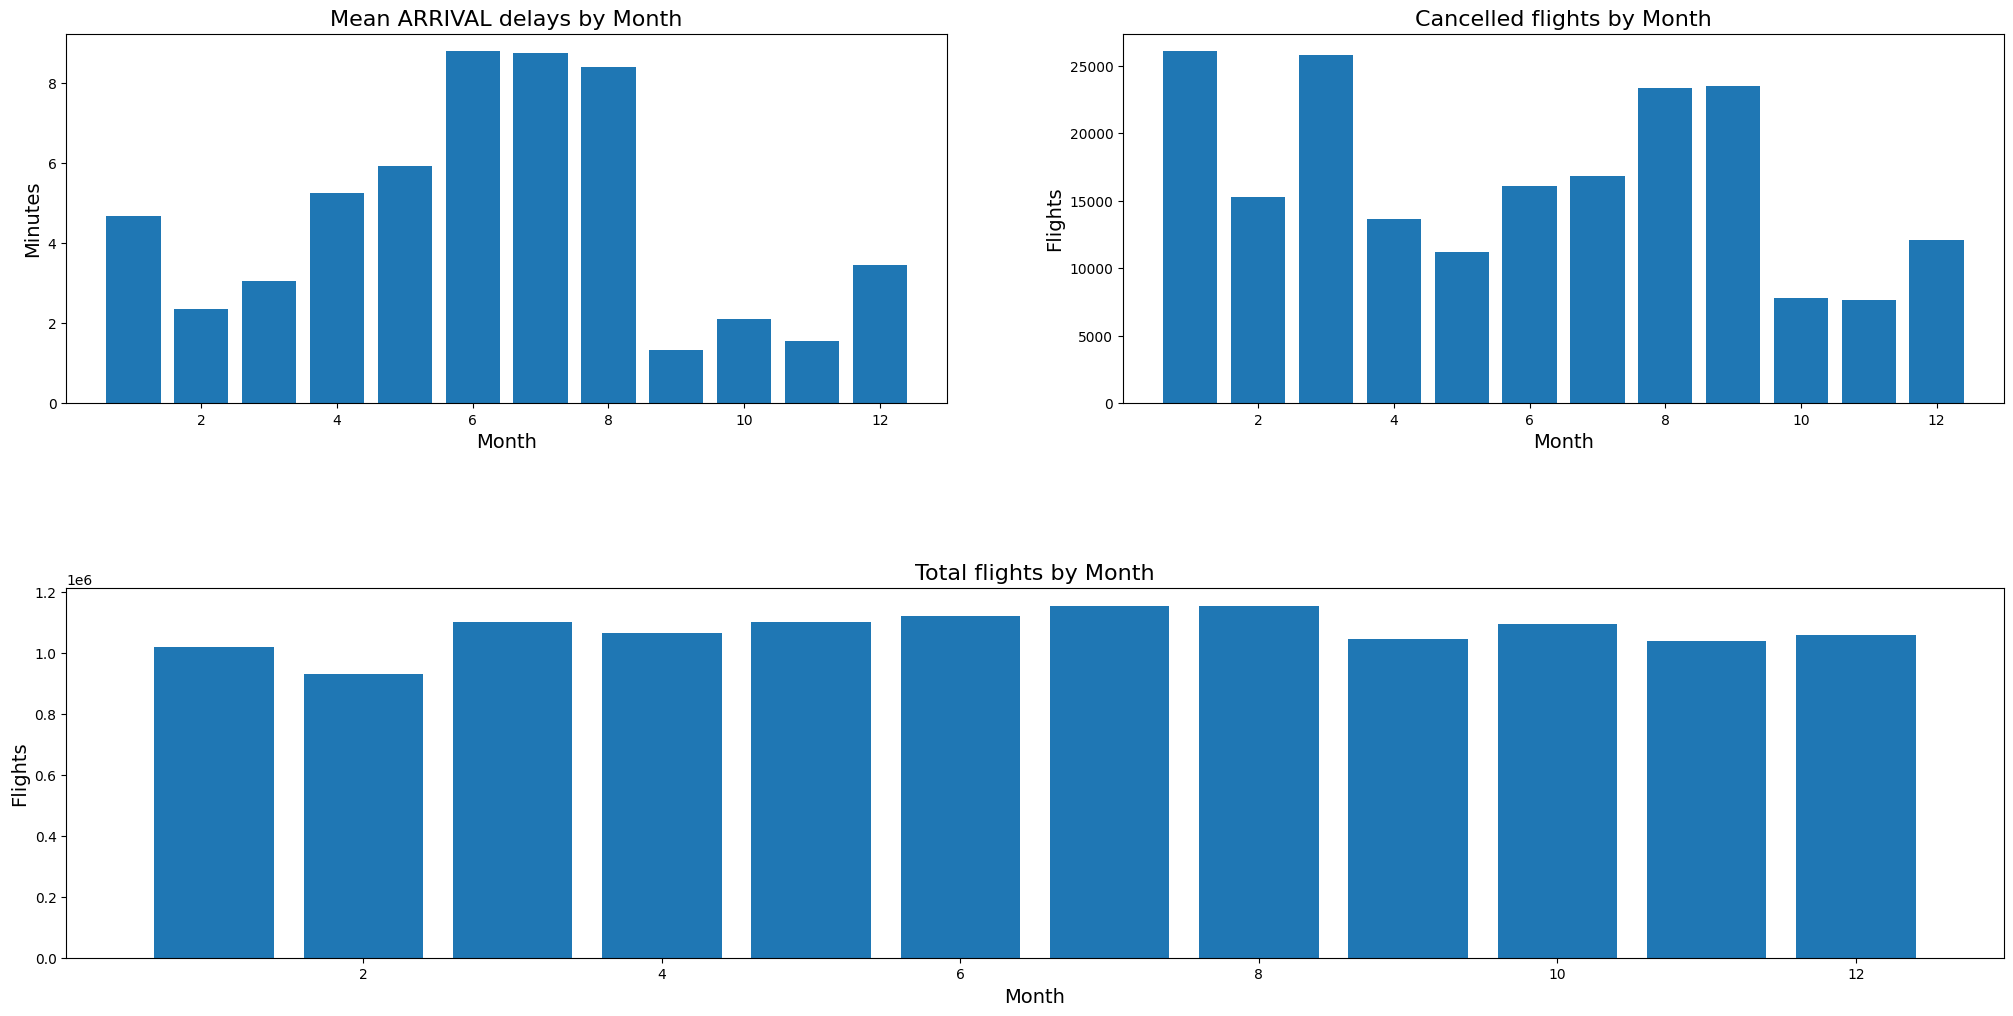

In [85]:
plt.figure(figsize=(25, 12)).subplots_adjust(hspace = 0.5)

temp_pdf= pdf3.sort_values(by = 'count', ascending=False)

ax = plt.subplot(2, 1 ,2)
ax.bar(temp_pdf.MONTH.values, temp_pdf['count'].values)
plt.title('Total flights by Month', fontsize=16)
plt.ylabel('Flights', fontsize=14)
plt.xlabel('Month', fontsize=14)


temp_pdf= pdf3.sort_values(by = 'avg(ARR_DELAY)', ascending=False)

ax = plt.subplot(2, 2 ,1)
ax.bar(temp_pdf.MONTH.values, temp_pdf['avg(ARR_DELAY)'].values)
plt.title('Mean ARRIVAL delays by Month', fontsize=16)
plt.ylabel('Minutes', fontsize=14)
plt.xlabel('Month', fontsize=14)


temp_pdf= pdf3.sort_values(by = 'sum(CANCELLED)', ascending=False)

ax = plt.subplot(2, 2 ,2)
ax.bar(temp_pdf.MONTH.values, temp_pdf['sum(CANCELLED)'].values)
plt.title('Cancelled flights by Month', fontsize=16)
plt.ylabel('Flights', fontsize=14)
plt.xlabel('Month', fontsize=14)


plt.show()

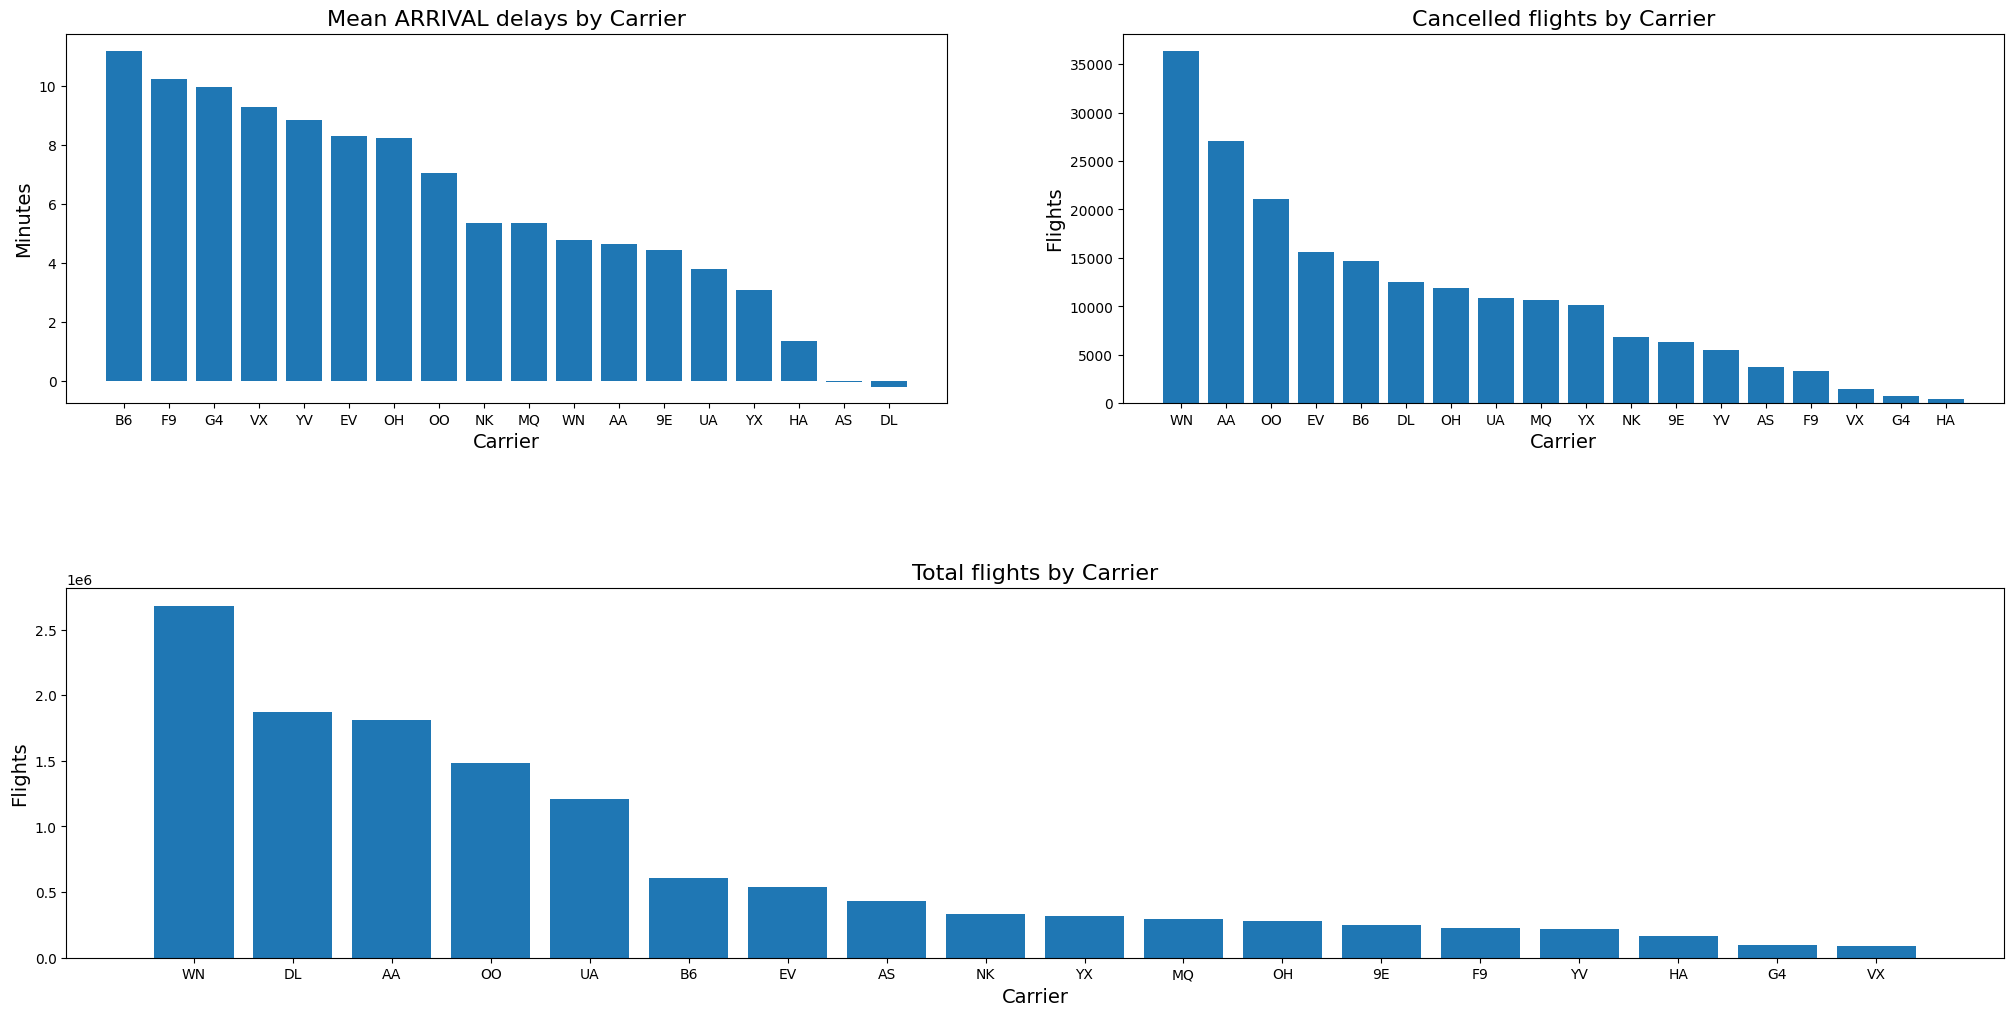

In [87]:
plt.figure(figsize=(25, 12)).subplots_adjust(hspace = 0.5)

temp_pdf= pdf4.sort_values(by = 'count', ascending=False)

ax = plt.subplot(2, 1 ,2)
ax.bar(temp_pdf.OP_CARRIER.values, temp_pdf['count'].values)
plt.title('Total flights by Carrier', fontsize=16)
plt.ylabel('Flights', fontsize=14)
plt.xlabel('Carrier', fontsize=14)


temp_pdf= pdf4.sort_values(by = 'avg(ARR_DELAY)', ascending=False)

ax = plt.subplot(2, 2 ,1)
ax.bar(temp_pdf.OP_CARRIER.values, temp_pdf['avg(ARR_DELAY)'].values)
plt.title('Mean ARRIVAL delays by Carrier', fontsize=16)
plt.ylabel('Minutes', fontsize=14)
plt.xlabel('Carrier', fontsize=14)


temp_pdf= pdf4.sort_values(by = 'sum(CANCELLED)', ascending=False)

ax = plt.subplot(2, 2 ,2)
ax.bar(temp_pdf.OP_CARRIER.values, temp_pdf['sum(CANCELLED)'].values)
plt.title('Cancelled flights by Carrier', fontsize=16)
plt.ylabel('Flights', fontsize=14)
plt.xlabel('Carrier', fontsize=14)


plt.show()

## Metrics of Near by Airports

In [89]:
pdf[(pdf.ORIGIN == 'IAD') | (pdf.ORIGIN == 'BWI') | (pdf.ORIGIN == 'DCA')]

,ORIGIN,sum(CANCELLED),count,avg(ARR_DELAY)
177,BWI,4050,207754,3.783191
29,DCA,5350,206925,4.297172
128,IAD,1436,105465,4.431340
